# ME 5920 FINAL PROJECT - SCIENTIFIC SIMULATIONS GROUP 1



## Group Members



1.   George Ayobami Thomas
2.   Mridul Bhattarai
3.   Hossein Asgaribakhtiari




## 1.1. Setup and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

Mounted at /content/drive


## 1.2. Load data from Google Drive (dataset 1)


In [2]:
DATA_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TRAIN_FD003.xlsx'
df = pd.read_excel(DATA_PATH)

# Inspect
print(df.head())

   Engine_ID  Cy_F    OP_1    OP_2  OP_3     S_1     S_2      S_3      S_4  \
0          1     1 -0.0005  0.0004   100  518.67  642.36  1583.23  1396.84   
1          1     2  0.0008 -0.0003   100  518.67  642.50  1584.69  1396.89   
2          1     3 -0.0014 -0.0002   100  518.67  642.18  1582.35  1405.61   
3          1     4 -0.0020  0.0001   100  518.67  642.92  1585.61  1392.27   
4          1     5  0.0016  0.0000   100  518.67  641.68  1588.63  1397.65   

     S_5  ...     S_14    S_15  S_16  S_17  S_18  S_19   S_20     S_21  \
0  14.62  ...  8145.32  8.4246  0.03   391  2388   100  39.11  23.3537   
1  14.62  ...  8152.85  8.4403  0.03   392  2388   100  38.99  23.4491   
2  14.62  ...  8150.17  8.3901  0.03   391  2388   100  38.85  23.3669   
3  14.62  ...  8146.56  8.3878  0.03   392  2388   100  38.96  23.2951   
4  14.62  ...  8147.80  8.3869  0.03   392  2388   100  39.14  23.4583   

   Unnamed: 26  RUL  
0          NaN  258  
1          NaN  257  
2          NaN  256 

## 1.3. Preprocessing and dataset definition


In [3]:
FEATURE_COLS = ['OP_1', 'OP_2', 'OP_3'] + [f'S_{i}' for i in range(1, 22)]
TARGET_COL = 'RUL'
ID_COL = 'Engine_ID'
CYCLE_COL = 'Cy_F'

print(df[ID_COL].shape)

'''# Normalize features per column
scaler = StandardScaler()
df[FEATURE_COLS] = scaler.fit_transform(df.loc[:, FEATURE_COLS])
# df[FEATURE_COLS] = scaler.fit_transform(df[FEATURE_COLS])'''

# Split engines into train/val
engine_ids = df[ID_COL].unique()
train_ids, val_ids = train_test_split(engine_ids, test_size=0.1, random_state=25)

(24720,)


## 1.4. Feature selection using correlation

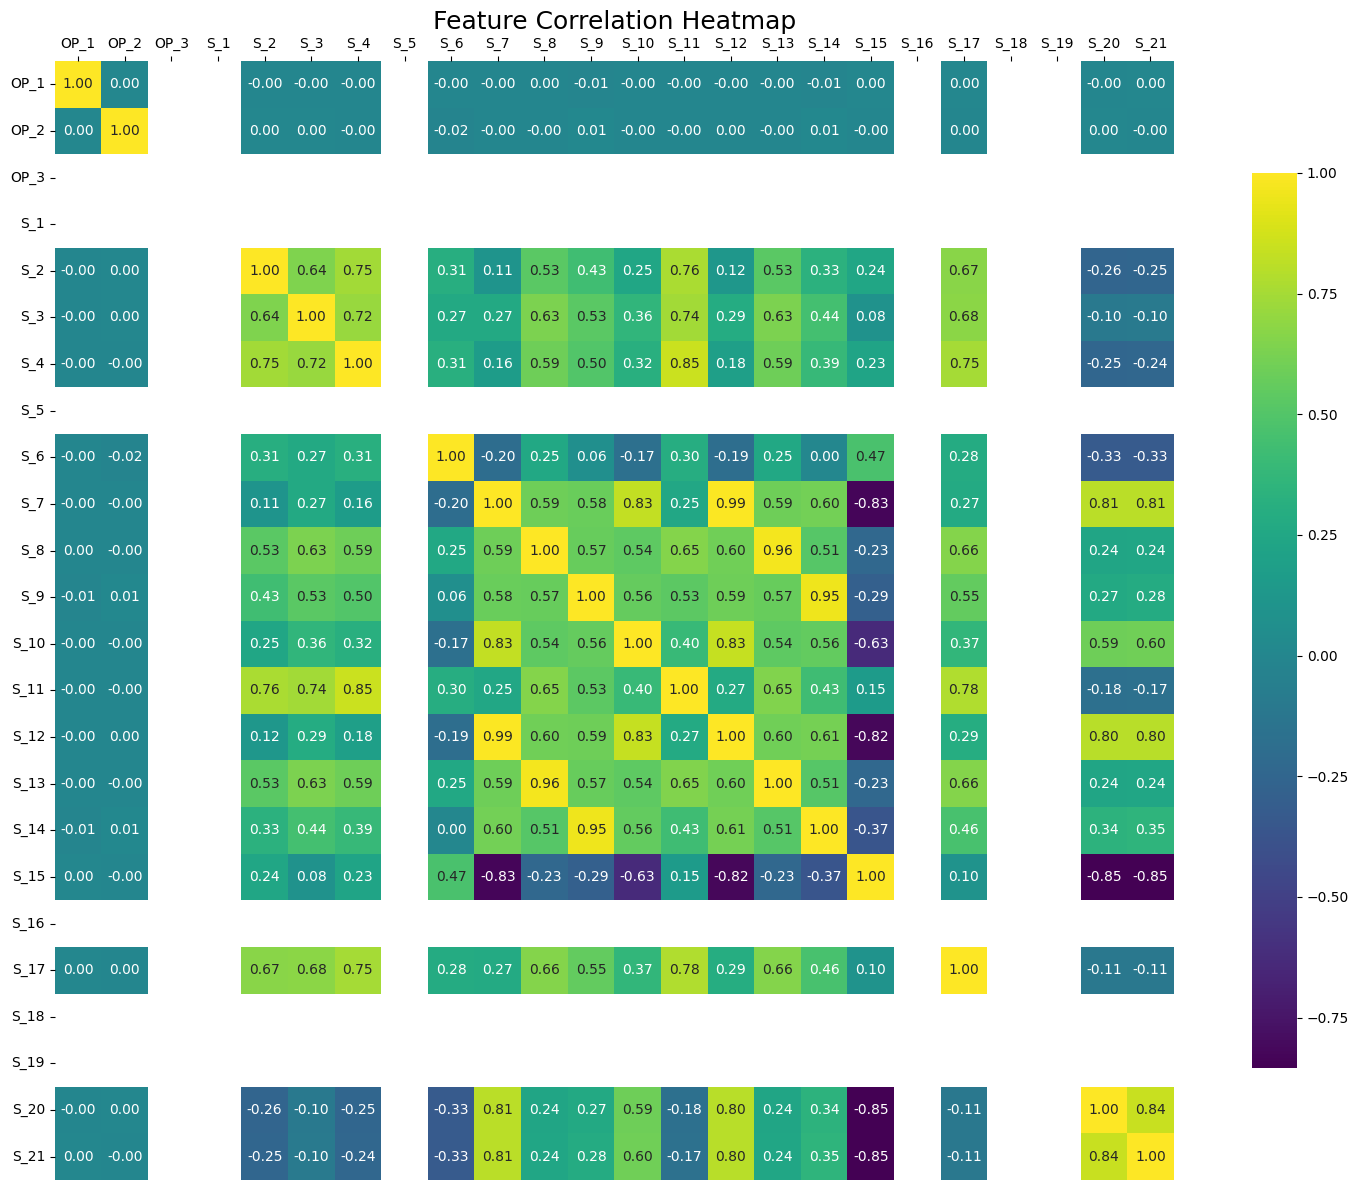

Removing 'S_12' due to high correlation (0.989) with 'S_7'
Removing 'S_13' due to high correlation (0.964) with 'S_8'
Removing 'S_14' due to high correlation (0.954) with 'S_9'
New Feature cols: 
 ['OP_1', 'OP_2', 'OP_3', 'S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_10', 'S_11', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_21']


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_train = df.loc[df[ID_COL].isin(train_ids), FEATURE_COLS]

# Compute correlation for alll the combination of two features
corr_matrix = X_train.corr()

# Plot
plt.figure(figsize=(16,12))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", square=True, cbar_kws={"shrink": .8})

# Title and ticks formatting
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.xaxis.set_ticks_position('top')# Move x-axis ticks to the top
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.show()


# Set to hold columns to drop
col_corr = set()

threshold = 0.95

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]

            if colname_i not in col_corr:
                print(f"Removing '{colname_i}' due to high correlation ({corr_matrix.iloc[i, j]:.3f}) with '{colname_j}'")
                col_corr.add(colname_i)
# New feature
New_Feature_Cols = [col for col in FEATURE_COLS if col not in col_corr]
print ("New Feature cols:","\n=================\n",New_Feature_Cols)

## 1.5. Drop the columns in 'train_corr' before applying scaling

In [5]:
df_raw = df.copy() #dataframe with all the features
df_corr = df.copy() #dataframe with reduced featres
df_corr = df_corr.drop(columns=col_corr)

#Normalize features per column
scaler_raw=StandardScaler()
scaler_corr=StandardScaler()

df_raw[FEATURE_COLS]=scaler_raw.fit_transform(df_raw.loc[:,FEATURE_COLS])
df_corr[New_Feature_Cols] = scaler_corr.fit_transform(df_corr.loc[:, New_Feature_Cols])

from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler = StandardScaler()
train_ruls = df.loc[df[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1,1)
rul_scaler.fit(train_ruls)

# New column 'RUL_s' for the scaled targets
df_raw['RUL_s'] = df_raw[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df_raw.loc[df_raw[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

df_corr['RUL_s'] = df_corr[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df_corr.loc[df_corr[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

# Scale val targets (so loss is computed on same scale)
val_ruls_raw = df_raw.loc[df_raw[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df_raw.loc[df_raw[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_raw)

val_ruls_corr = df_corr.loc[df_corr[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df_corr.loc[df_corr[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_corr)
# Update target column name
TARGET_COL_S = 'RUL_s'


def make_sequences(Feature_Cols, df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[Feature_Cols].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

WINDOW_SIZE = 1

train_seqs_raw = make_sequences(FEATURE_COLS, df_raw, train_ids, WINDOW_SIZE)
val_seqs_raw   = make_sequences(FEATURE_COLS, df_raw, val_ids, WINDOW_SIZE)

train_seqs_corr = make_sequences(New_Feature_Cols, df_corr, train_ids, WINDOW_SIZE)
val_seqs_corr  = make_sequences(New_Feature_Cols, df_corr, val_ids, WINDOW_SIZE)

class SequenceDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        x, y = self.seqs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_ds_raw = SequenceDataset(train_seqs_raw)
val_ds_raw   = SequenceDataset(val_seqs_raw)

train_loader_raw = DataLoader(train_ds_raw, batch_size=64, shuffle=False)
val_loader_raw   = DataLoader(val_ds_raw, batch_size=64)


train_ds_corr = SequenceDataset(train_seqs_corr)
val_ds_corr  = SequenceDataset(val_seqs_corr)

train_loader_corr = DataLoader(train_ds_corr, batch_size=64, shuffle=False)
val_loader_corr   = DataLoader(val_ds_corr, batch_size=64)

## 2.1. Long Short-Term Memory (LSTM) model definition

In [6]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.fc(last).squeeze()

## 2.2. Transformer model definition

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_enc  = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out      = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        last = x[:, -1, :]
        return self.fc_out(last).squeeze()

## 2.3. Fully Connected Neural Network (FCNN) definition

In [8]:
class FCRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64]):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

## 2.3.1. Flattened dataset for FCNN

In [9]:
class FlattenedDataset(Dataset):
    def __init__(self, seqs):
        self.x = [torch.tensor(s[0].flatten(), dtype=torch.float32) for s in seqs]
        self.y = [torch.tensor(s[1], dtype=torch.float32) for s in seqs]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

flat_train_ds_raw = FlattenedDataset(train_seqs_raw)
flat_val_ds_raw   = FlattenedDataset(val_seqs_raw)

flat_train_loader_raw = DataLoader(flat_train_ds_raw, batch_size=64)
flat_val_loader_raw   = DataLoader(flat_val_ds_raw, batch_size=64)

flat_train_ds_corr = FlattenedDataset(train_seqs_corr)
flat_val_ds_corr   = FlattenedDataset(val_seqs_corr)

flat_train_loader_corr = DataLoader(flat_train_ds_corr, batch_size=64)
flat_val_loader_corr   = DataLoader(flat_val_ds_corr, batch_size=64)

## 2.4. Convolutional Neural Network (CNN) regression model

In [10]:
class CNNRegressor(nn.Module):
    def __init__(self, num_features, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        # x: [batch, window_size, features]
        x = x.permute(0, 2, 1)  # → [batch, features, window]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # → [batch, 64]
        return self.fc(x).squeeze(-1)  # → [batch]

## 3. Training and evaluation functions

In [11]:
def train_epoch(model, loader, optim, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optim.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

## 4.1. Running LSTM


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm   = LSTMRegressor(input_dim=len(FEATURE_COLS), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm, train_loader_raw, opt_lstm, crit, device)
    val_loss   = eval_model(lstm, val_loader_raw, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.4835, Val MSE=0.5410
Epoch 2: LSTM Train MSE=0.4135, Val MSE=0.5263
Epoch 3: LSTM Train MSE=0.4036, Val MSE=0.5247
Epoch 4: LSTM Train MSE=0.3976, Val MSE=0.5266
Epoch 5: LSTM Train MSE=0.3934, Val MSE=0.5292
Epoch 6: LSTM Train MSE=0.3899, Val MSE=0.5318
Epoch 7: LSTM Train MSE=0.3867, Val MSE=0.5343
Epoch 8: LSTM Train MSE=0.3836, Val MSE=0.5366
Epoch 9: LSTM Train MSE=0.3807, Val MSE=0.5386
Epoch 10: LSTM Train MSE=0.3781, Val MSE=0.5407
Epoch 11: LSTM Train MSE=0.3755, Val MSE=0.5425
Epoch 12: LSTM Train MSE=0.3731, Val MSE=0.5442
Epoch 13: LSTM Train MSE=0.3709, Val MSE=0.5457
Epoch 14: LSTM Train MSE=0.3689, Val MSE=0.5471
Epoch 15: LSTM Train MSE=0.3670, Val MSE=0.5486
Epoch 16: LSTM Train MSE=0.3652, Val MSE=0.5502
Epoch 17: LSTM Train MSE=0.3636, Val MSE=0.5514
Epoch 18: LSTM Train MSE=0.3622, Val MSE=0.5527
Epoch 19: LSTM Train MSE=0.3606, Val MSE=0.5541
Epoch 20: LSTM Train MSE=0.3593, Val MSE=0.5555
Epoch 21: LSTM Train MSE=0.3581, Val MSE=0.5567
E

## 4.2. Running Transformer


In [13]:
trans   = TransformerRegressor(input_dim=len(FEATURE_COLS), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans, train_loader_raw, opt_trans, crit, device)
    val_loss   = eval_model(trans, val_loader_raw, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=0.7163, Val MSE=0.6507
Epoch 2: Trans Train MSE=0.5482, Val MSE=0.6249
Epoch 3: Trans Train MSE=0.5151, Val MSE=0.5340
Epoch 4: Trans Train MSE=0.4902, Val MSE=0.5330
Epoch 5: Trans Train MSE=0.4713, Val MSE=0.5471
Epoch 6: Trans Train MSE=0.4583, Val MSE=0.5410
Epoch 7: Trans Train MSE=0.6327, Val MSE=0.7492
Epoch 8: Trans Train MSE=0.5786, Val MSE=0.7445
Epoch 9: Trans Train MSE=0.5293, Val MSE=0.4968
Epoch 10: Trans Train MSE=0.5078, Val MSE=0.4742
Epoch 11: Trans Train MSE=0.4837, Val MSE=0.4739
Epoch 12: Trans Train MSE=0.4625, Val MSE=0.4605
Epoch 13: Trans Train MSE=0.4619, Val MSE=0.4642
Epoch 14: Trans Train MSE=0.4506, Val MSE=0.4632
Epoch 15: Trans Train MSE=0.4555, Val MSE=0.4530
Epoch 16: Trans Train MSE=0.4475, Val MSE=0.4598
Epoch 17: Trans Train MSE=0.4738, Val MSE=0.4642
Epoch 18: Trans Train MSE=0.4515, Val MSE=0.4566
Epoch 19: Trans Train MSE=0.4465, Val MSE=0.4511
Epoch 20: Trans Train MSE=0.4385, Val MSE=0.4503
Epoch 21: Trans Train MSE=0.4

## 4.3. Running FCNN


In [14]:
fcnn = FCRegressor(input_dim=len(FEATURE_COLS) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn, flat_train_loader_raw, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn, flat_val_loader_raw, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.4646, Val MSE=0.6118
Epoch 2: FCNN Train MSE=0.4251, Val MSE=0.5743
Epoch 3: FCNN Train MSE=0.4098, Val MSE=0.5612
Epoch 4: FCNN Train MSE=0.4020, Val MSE=0.5528
Epoch 5: FCNN Train MSE=0.3965, Val MSE=0.5466
Epoch 6: FCNN Train MSE=0.3920, Val MSE=0.5415
Epoch 7: FCNN Train MSE=0.3880, Val MSE=0.5378
Epoch 8: FCNN Train MSE=0.3849, Val MSE=0.5350
Epoch 9: FCNN Train MSE=0.3819, Val MSE=0.5322
Epoch 10: FCNN Train MSE=0.3791, Val MSE=0.5302
Epoch 11: FCNN Train MSE=0.3765, Val MSE=0.5289
Epoch 12: FCNN Train MSE=0.3744, Val MSE=0.5275
Epoch 13: FCNN Train MSE=0.3726, Val MSE=0.5267
Epoch 14: FCNN Train MSE=0.3705, Val MSE=0.5252
Epoch 15: FCNN Train MSE=0.3689, Val MSE=0.5251
Epoch 16: FCNN Train MSE=0.3675, Val MSE=0.5244
Epoch 17: FCNN Train MSE=0.3664, Val MSE=0.5228
Epoch 18: FCNN Train MSE=0.3652, Val MSE=0.5228
Epoch 19: FCNN Train MSE=0.3643, Val MSE=0.5222
Epoch 20: FCNN Train MSE=0.3633, Val MSE=0.5218
Epoch 21: FCNN Train MSE=0.3625, Val MSE=0.5205
E

## 4.4. Running CNN

In [15]:
cnn_model = CNNRegressor(num_features=len(FEATURE_COLS), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)



for epoch in range(1, 101):
    cnn_model.train()
    total_loss = 0
    for xb, yb in train_loader_raw:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_raw.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_raw:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_raw.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')


Epoch 1: CNN Train Loss=0.5366, Val Loss=0.5675
Epoch 2: CNN Train Loss=0.4111, Val Loss=0.5480
Epoch 3: CNN Train Loss=0.3997, Val Loss=0.5381
Epoch 4: CNN Train Loss=0.3938, Val Loss=0.5317
Epoch 5: CNN Train Loss=0.3886, Val Loss=0.5281
Epoch 6: CNN Train Loss=0.3850, Val Loss=0.5252
Epoch 7: CNN Train Loss=0.3818, Val Loss=0.5230
Epoch 8: CNN Train Loss=0.3790, Val Loss=0.5203
Epoch 9: CNN Train Loss=0.3765, Val Loss=0.5184
Epoch 10: CNN Train Loss=0.3741, Val Loss=0.5167
Epoch 11: CNN Train Loss=0.3724, Val Loss=0.5160
Epoch 12: CNN Train Loss=0.3707, Val Loss=0.5143
Epoch 13: CNN Train Loss=0.3694, Val Loss=0.5142
Epoch 14: CNN Train Loss=0.3677, Val Loss=0.5127
Epoch 15: CNN Train Loss=0.3667, Val Loss=0.5129
Epoch 16: CNN Train Loss=0.3665, Val Loss=0.5108
Epoch 17: CNN Train Loss=0.3654, Val Loss=0.5115
Epoch 18: CNN Train Loss=0.3638, Val Loss=0.5111
Epoch 19: CNN Train Loss=0.3627, Val Loss=0.5113
Epoch 20: CNN Train Loss=0.3617, Val Loss=0.5110
Epoch 21: CNN Train Loss=0.36

## 5. Compare final validation losses

In [16]:
lstm_val  = eval_model(lstm, train_loader_raw, crit, device)
trans_val = eval_model(trans, train_loader_raw, crit, device)
fcnn_val  = eval_model(fcnn, flat_train_loader_raw, crit, device)
cnn_val   = eval_model(cnn_model, train_loader_raw, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3169, Transformer: 0.3276, FCNN: 0.3145, CNN: 0.3215


## 6. Load test data and run inference

In [17]:
import matplotlib.pyplot as plt

TEST_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TEST_FD003.xlsx'
test_df   = pd.read_excel(TEST_PATH)

test_df_raw=test_df.copy()

# Remove columns that are in the col_corr set
test_df_corr=test_df.copy()
test_df_corr = test_df_corr.drop(columns=col_corr, errors='ignore')
test_df_corr.reset_index(drop=True, inplace=True)

# Apply same scaling
# test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS])
test_df_raw[FEATURE_COLS] = scaler_raw.transform(test_df_raw.loc[:, FEATURE_COLS])
test_df_raw[TARGET_COL_S] = rul_scaler.transform(test_df_raw[[TARGET_COL]])

test_df_corr[New_Feature_Cols] = scaler_corr.transform(test_df_corr.loc[:, New_Feature_Cols])
test_df_corr[TARGET_COL_S] = rul_scaler.transform(test_df_corr[[TARGET_COL]])

def make_test_sequences(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[FEATURE_COLS].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm(x_win).item())
                preds_t.append(trans(x_win).item())
                preds_f.append(fcnn(x_win).item())
                preds_c.append(cnn_model(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences(test_df_raw, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#7. Plot and save for a chosen engine

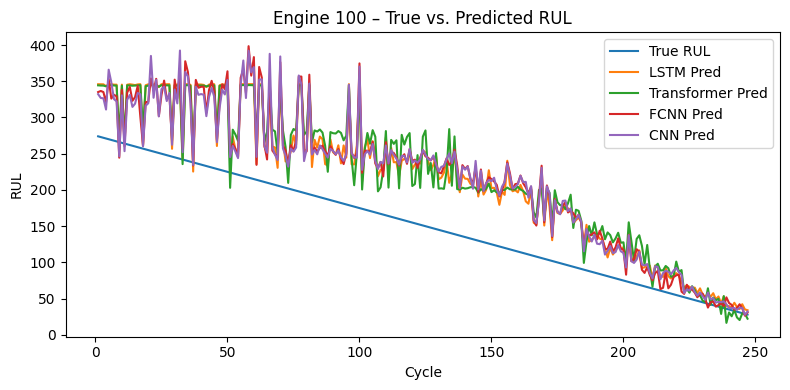

In [18]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]


true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.show()

## 8.1. Running LSTM using new feature columns

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_corr   = LSTMRegressor(input_dim=len(New_Feature_Cols), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm_corr.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm_corr, train_loader_corr, opt_lstm, crit, device)
    val_loss   = eval_model(lstm_corr, val_loader_corr, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.4980, Val MSE=0.5415
Epoch 2: LSTM Train MSE=0.4194, Val MSE=0.5345
Epoch 3: LSTM Train MSE=0.4094, Val MSE=0.5338
Epoch 4: LSTM Train MSE=0.4032, Val MSE=0.5353
Epoch 5: LSTM Train MSE=0.3988, Val MSE=0.5374
Epoch 6: LSTM Train MSE=0.3954, Val MSE=0.5396
Epoch 7: LSTM Train MSE=0.3923, Val MSE=0.5416
Epoch 8: LSTM Train MSE=0.3896, Val MSE=0.5435
Epoch 9: LSTM Train MSE=0.3869, Val MSE=0.5452
Epoch 10: LSTM Train MSE=0.3844, Val MSE=0.5467
Epoch 11: LSTM Train MSE=0.3820, Val MSE=0.5481
Epoch 12: LSTM Train MSE=0.3797, Val MSE=0.5494
Epoch 13: LSTM Train MSE=0.3775, Val MSE=0.5505
Epoch 14: LSTM Train MSE=0.3755, Val MSE=0.5516
Epoch 15: LSTM Train MSE=0.3735, Val MSE=0.5527
Epoch 16: LSTM Train MSE=0.3718, Val MSE=0.5541
Epoch 17: LSTM Train MSE=0.3701, Val MSE=0.5553
Epoch 18: LSTM Train MSE=0.3685, Val MSE=0.5564
Epoch 19: LSTM Train MSE=0.3671, Val MSE=0.5577
Epoch 20: LSTM Train MSE=0.3658, Val MSE=0.5589
Epoch 21: LSTM Train MSE=0.3646, Val MSE=0.5596
E

## 8.2. Running Transformer using new feature columns

In [20]:
trans_corr   = TransformerRegressor(input_dim=len(New_Feature_Cols), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans_corr.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans_corr, train_loader_corr, opt_trans, crit, device)
    val_loss   = eval_model(trans_corr, val_loader_corr, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=0.7043, Val MSE=0.6792
Epoch 2: Trans Train MSE=0.5629, Val MSE=0.5895
Epoch 3: Trans Train MSE=0.5026, Val MSE=0.5742
Epoch 4: Trans Train MSE=0.5106, Val MSE=0.5680
Epoch 5: Trans Train MSE=0.4871, Val MSE=0.5345
Epoch 6: Trans Train MSE=0.4724, Val MSE=0.5204
Epoch 7: Trans Train MSE=0.4563, Val MSE=0.5241
Epoch 8: Trans Train MSE=0.4451, Val MSE=0.5036
Epoch 9: Trans Train MSE=0.4359, Val MSE=0.5424
Epoch 10: Trans Train MSE=0.4324, Val MSE=0.5040
Epoch 11: Trans Train MSE=0.4327, Val MSE=0.5089
Epoch 12: Trans Train MSE=0.4185, Val MSE=0.5646
Epoch 13: Trans Train MSE=0.4172, Val MSE=0.5345
Epoch 14: Trans Train MSE=0.4160, Val MSE=0.5400
Epoch 15: Trans Train MSE=0.4120, Val MSE=0.5585
Epoch 16: Trans Train MSE=0.4112, Val MSE=0.5667
Epoch 17: Trans Train MSE=0.4118, Val MSE=0.5657
Epoch 18: Trans Train MSE=0.4026, Val MSE=0.5512
Epoch 19: Trans Train MSE=0.3985, Val MSE=0.5429
Epoch 20: Trans Train MSE=0.3932, Val MSE=0.5597
Epoch 21: Trans Train MSE=0.3

## 8.3. Running FCNN using new feature columns

In [21]:
fcnn_corr = FCRegressor(input_dim=len(New_Feature_Cols) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn_corr.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn_corr, flat_train_loader_corr, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn_corr, flat_val_loader_corr, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.4831, Val MSE=0.5813
Epoch 2: FCNN Train MSE=0.4240, Val MSE=0.5795
Epoch 3: FCNN Train MSE=0.4113, Val MSE=0.5686
Epoch 4: FCNN Train MSE=0.4022, Val MSE=0.5608
Epoch 5: FCNN Train MSE=0.3961, Val MSE=0.5549
Epoch 6: FCNN Train MSE=0.3912, Val MSE=0.5506
Epoch 7: FCNN Train MSE=0.3872, Val MSE=0.5468
Epoch 8: FCNN Train MSE=0.3837, Val MSE=0.5437
Epoch 9: FCNN Train MSE=0.3809, Val MSE=0.5413
Epoch 10: FCNN Train MSE=0.3784, Val MSE=0.5386
Epoch 11: FCNN Train MSE=0.3764, Val MSE=0.5365
Epoch 12: FCNN Train MSE=0.3744, Val MSE=0.5356
Epoch 13: FCNN Train MSE=0.3728, Val MSE=0.5337
Epoch 14: FCNN Train MSE=0.3714, Val MSE=0.5327
Epoch 15: FCNN Train MSE=0.3702, Val MSE=0.5319
Epoch 16: FCNN Train MSE=0.3690, Val MSE=0.5305
Epoch 17: FCNN Train MSE=0.3689, Val MSE=0.5321
Epoch 18: FCNN Train MSE=0.3674, Val MSE=0.5293
Epoch 19: FCNN Train MSE=0.3664, Val MSE=0.5288
Epoch 20: FCNN Train MSE=0.3656, Val MSE=0.5283
Epoch 21: FCNN Train MSE=0.3650, Val MSE=0.5277
E

## 8.4. Running CNN using new feature columns

In [22]:
cnn_model_corr = CNNRegressor(num_features=len(New_Feature_Cols), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model_corr.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(1, 101):
    cnn_model_corr.train()
    total_loss = 0
    for xb, yb in train_loader_corr:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model_corr(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_corr.dataset)

    # Validation
    cnn_model_corr.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_corr:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model_corr(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_corr.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')


Epoch 1: CNN Train Loss=0.5375, Val Loss=0.5560
Epoch 2: CNN Train Loss=0.4134, Val Loss=0.5428
Epoch 3: CNN Train Loss=0.4018, Val Loss=0.5384
Epoch 4: CNN Train Loss=0.3950, Val Loss=0.5356
Epoch 5: CNN Train Loss=0.3898, Val Loss=0.5322
Epoch 6: CNN Train Loss=0.3860, Val Loss=0.5295
Epoch 7: CNN Train Loss=0.3828, Val Loss=0.5263
Epoch 8: CNN Train Loss=0.3803, Val Loss=0.5239
Epoch 9: CNN Train Loss=0.3780, Val Loss=0.5213
Epoch 10: CNN Train Loss=0.3761, Val Loss=0.5192
Epoch 11: CNN Train Loss=0.3745, Val Loss=0.5182
Epoch 12: CNN Train Loss=0.3728, Val Loss=0.5163
Epoch 13: CNN Train Loss=0.3713, Val Loss=0.5152
Epoch 14: CNN Train Loss=0.3702, Val Loss=0.5155
Epoch 15: CNN Train Loss=0.3689, Val Loss=0.5152
Epoch 16: CNN Train Loss=0.3681, Val Loss=0.5150
Epoch 17: CNN Train Loss=0.3672, Val Loss=0.5151
Epoch 18: CNN Train Loss=0.3665, Val Loss=0.5148
Epoch 19: CNN Train Loss=0.3658, Val Loss=0.5154
Epoch 20: CNN Train Loss=0.3651, Val Loss=0.5160
Epoch 21: CNN Train Loss=0.36

## 9. Comparing final validation losses for new feature columns

In [23]:
lstm_val  = eval_model(lstm_corr, train_loader_corr, crit, device)
trans_val = eval_model(trans_corr, train_loader_corr, crit, device)
fcnn_val  = eval_model(fcnn_corr, flat_train_loader_corr, crit, device)
cnn_val   = eval_model(cnn_model_corr, train_loader_corr, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3238, Transformer: 0.3373, FCNN: 0.3041, CNN: 0.3252


## 10. Load test data and run inference for new feature columns

In [26]:
def make_test_sequences_corr(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[New_Feature_Cols].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm_corr(x_win).item())
                preds_t.append(trans_corr(x_win).item())
                preds_f.append(fcnn_corr(x_win).item())
                preds_c.append(cnn_model_corr(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

In [27]:
test_seqs_corr = make_test_sequences_corr(test_df_corr, WINDOW_SIZE)


## 11.1. Plot for a chosen engine using new feature columns

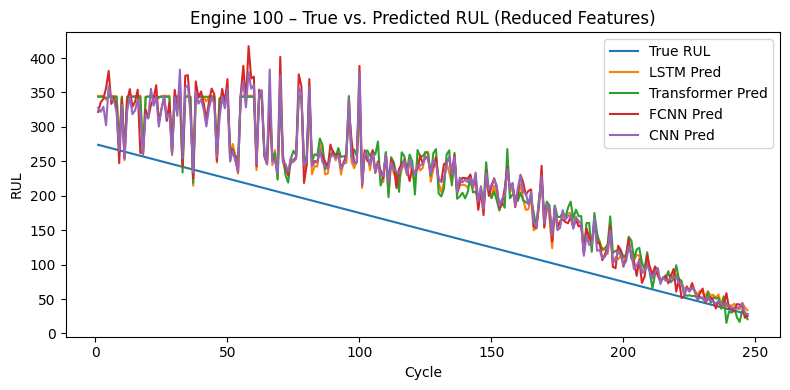

In [28]:
engine_id_corr = list(test_seqs_corr.keys())[99]  # change as desired
seq_corr       = test_seqs_corr[engine_id_corr]


true_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq_corr['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq_corr['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq_corr['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq_corr['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq_corr['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq_corr['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq_corr['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id_corr} – True vs. Predicted RUL (Reduced Features)')
plt.legend()
plt.tight_layout()
plt.show()

## 12. PCA whitening

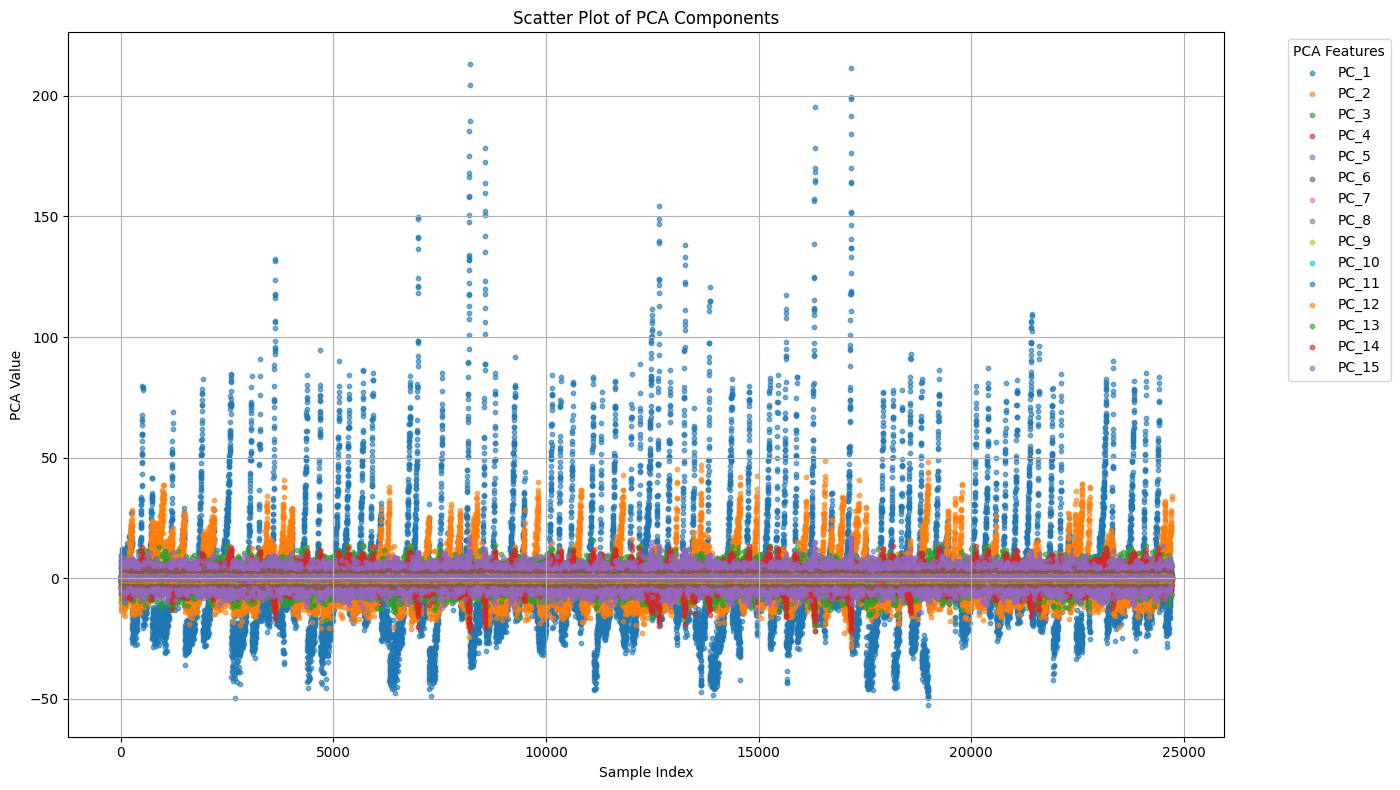

In [29]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% variance
pca = PCA(n_components=15)
pca_features = pca.fit_transform(df[FEATURE_COLS])

# Create new PCA column names and replace original features
feature_cols_pca = [f'PC_{i+1}' for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_features, columns=feature_cols_pca, index=df.index)

# Optional: downsample if too large
df_pca_plot_sample = df_pca.sample(n=20000, random_state=42) if len(df_pca) > 20000 else df_pca

# Create a scatter plot of all PCA components
plt.figure(figsize=(14, 8))

# Plot each PCA component in a different color
for i, col in enumerate(df_pca.columns):
    plt.scatter(df_pca_plot_sample.index, df_pca_plot_sample[col],
                label=col, s=10, alpha=0.6)

plt.title("Scatter Plot of PCA Components")
plt.xlabel("Sample Index")
plt.ylabel("PCA Value")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), title="PCA Features")
plt.grid(True)
plt.tight_layout()
plt.show()

## 12.1. Create a copy of df for PCA transformation

In [30]:
df_pca_applied = df.copy()

# Drop original feature columns from the copy
df_pca_applied.drop(columns=FEATURE_COLS, inplace=True)

# Add PCA-transformed features to the copy
df_pca_applied = pd.concat([df_pca_applied, df_pca], axis=1)

from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler_pca = StandardScaler()
train_ruls_pca = df_pca_applied.loc[df_pca_applied[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1, 1)
rul_scaler_pca.fit(train_ruls_pca)

# New column 'RUL_s' for the scaled targets
df_pca_applied['RUL_s'] = df_pca_applied[TARGET_COL].astype(np.float64).values.reshape(-1, 1)
df_pca_applied.loc[df_pca_applied[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls_pca)

# Scale val targets (so loss is computed on same scale)
val_ruls_pca = df_pca_applied.loc[df_pca_applied[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1, 1)
df_pca_applied.loc[df_pca_applied[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_pca)

print(df_pca_applied.head)

<bound method NDFrame.head of        Engine_ID  Cy_F  Unnamed: 26  RUL      PC_1       PC_2      PC_3  \
0              1     1          NaN  258 -3.226499  -8.753948 -1.178559   
1              1     2          NaN  257  1.356720 -10.156783  0.404789   
2              1     3          NaN  256  7.379692  -3.843023 -6.279806   
3              1     4          NaN  255 -1.100450 -11.986071  2.735500   
4              1     5          NaN  254  9.779657  -7.350391  1.493195   
...          ...   ...          ...  ...       ...        ...       ...   
24715        100   148          NaN    4  5.982098  21.805816 -4.289538   
24716        100   149          NaN    3  6.252954  24.831654 -5.009633   
24717        100   150          NaN    2  1.916662  33.069285  0.398717   
24718        100   151          NaN    1  2.163707  24.385276 -3.100134   
24719        100   152          NaN    0  4.941128  33.977289 -6.383865   

           PC_4      PC_5      PC_6      PC_7      PC_8      PC_9    

## 12.2. PCA-based sequence preparation

In [31]:
def make_sequences_pca(df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[feature_cols_pca].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

## 12.3. Data loader construction for PCA-based time-series sequences

In [32]:
WINDOW_SIZE = 1

train_seqs_pca = make_sequences_pca(df_pca_applied, train_ids, WINDOW_SIZE)
val_seqs_pca   = make_sequences_pca(df_pca_applied, val_ids, WINDOW_SIZE)

train_ds_pca = SequenceDataset(train_seqs_pca)
val_ds_pca   = SequenceDataset(val_seqs_pca)

train_loader_pca = DataLoader(train_ds_pca, batch_size=64, shuffle=False)
val_loader_pca   = DataLoader(val_ds_pca, batch_size=64)

## 12.4. Data loader initialization for flattened PCA-based sequences

In [33]:
flat_train_ds_pca = FlattenedDataset(train_seqs_pca)
flat_val_ds_pca   = FlattenedDataset(val_seqs_pca)

flat_train_loader_pca = DataLoader(flat_train_ds_pca, batch_size=64)
flat_val_loader_pca   = DataLoader(flat_val_ds_pca, batch_size=64)

## 13.1. Running LSTM for PCA-whitened data

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pca   = LSTMRegressor(input_dim=len(feature_cols_pca), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm_pca.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm_pca, train_loader_pca, opt_lstm, crit, device)
    val_loss   = eval_model(lstm_pca, val_loader_pca, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.4972, Val MSE=0.5012
Epoch 2: LSTM Train MSE=0.4362, Val MSE=0.5140
Epoch 3: LSTM Train MSE=0.4248, Val MSE=0.5222
Epoch 4: LSTM Train MSE=0.4169, Val MSE=0.5281
Epoch 5: LSTM Train MSE=0.4111, Val MSE=0.5328
Epoch 6: LSTM Train MSE=0.4064, Val MSE=0.5366
Epoch 7: LSTM Train MSE=0.4024, Val MSE=0.5398
Epoch 8: LSTM Train MSE=0.3993, Val MSE=0.5425
Epoch 9: LSTM Train MSE=0.3965, Val MSE=0.5448
Epoch 10: LSTM Train MSE=0.3942, Val MSE=0.5471
Epoch 11: LSTM Train MSE=0.3921, Val MSE=0.5492
Epoch 12: LSTM Train MSE=0.3903, Val MSE=0.5512
Epoch 13: LSTM Train MSE=0.3889, Val MSE=0.5527
Epoch 14: LSTM Train MSE=0.3873, Val MSE=0.5545
Epoch 15: LSTM Train MSE=0.3859, Val MSE=0.5562
Epoch 16: LSTM Train MSE=0.3847, Val MSE=0.5579
Epoch 17: LSTM Train MSE=0.3836, Val MSE=0.5595
Epoch 18: LSTM Train MSE=0.3825, Val MSE=0.5613
Epoch 19: LSTM Train MSE=0.3816, Val MSE=0.5631
Epoch 20: LSTM Train MSE=0.3806, Val MSE=0.5651
Epoch 21: LSTM Train MSE=0.3801, Val MSE=0.5665
E

## 13.2. Running Transformer for PCA-whitened data

In [35]:
trans_pca   = TransformerRegressor(input_dim=len(feature_cols_pca), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans_pca.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans_pca, train_loader_pca, opt_trans, crit, device)
    val_loss   = eval_model(trans_pca, val_loader_pca, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=0.7509, Val MSE=0.7030
Epoch 2: Trans Train MSE=0.6193, Val MSE=0.6763
Epoch 3: Trans Train MSE=0.5717, Val MSE=0.6162
Epoch 4: Trans Train MSE=0.5548, Val MSE=0.6207
Epoch 5: Trans Train MSE=0.5280, Val MSE=0.5591
Epoch 6: Trans Train MSE=0.5163, Val MSE=0.5574
Epoch 7: Trans Train MSE=0.5007, Val MSE=0.6143
Epoch 8: Trans Train MSE=0.5206, Val MSE=0.6040
Epoch 9: Trans Train MSE=0.4981, Val MSE=0.5615
Epoch 10: Trans Train MSE=0.4800, Val MSE=0.5264
Epoch 11: Trans Train MSE=0.4745, Val MSE=0.5109
Epoch 12: Trans Train MSE=0.4684, Val MSE=0.5265
Epoch 13: Trans Train MSE=0.5320, Val MSE=0.5097
Epoch 14: Trans Train MSE=0.4744, Val MSE=0.5115
Epoch 15: Trans Train MSE=0.4589, Val MSE=0.5309
Epoch 16: Trans Train MSE=0.4488, Val MSE=0.5199
Epoch 17: Trans Train MSE=0.4472, Val MSE=0.5300
Epoch 18: Trans Train MSE=0.4453, Val MSE=0.5229
Epoch 19: Trans Train MSE=0.4361, Val MSE=0.5188
Epoch 20: Trans Train MSE=0.4411, Val MSE=0.5169
Epoch 21: Trans Train MSE=0.4

## 13.3. Running FCNN for PCA-whitened data

In [36]:
fcnn_pca = FCRegressor(input_dim=len(feature_cols_pca) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn_pca.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn_pca, flat_train_loader_pca, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn_pca, flat_val_loader_pca, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.6512, Val MSE=0.5884
Epoch 2: FCNN Train MSE=0.5553, Val MSE=0.5532
Epoch 3: FCNN Train MSE=0.4407, Val MSE=0.5499
Epoch 4: FCNN Train MSE=0.4291, Val MSE=0.5531
Epoch 5: FCNN Train MSE=0.4262, Val MSE=0.5523
Epoch 6: FCNN Train MSE=0.4223, Val MSE=0.5560
Epoch 7: FCNN Train MSE=0.4191, Val MSE=0.5584
Epoch 8: FCNN Train MSE=0.4166, Val MSE=0.5558
Epoch 9: FCNN Train MSE=0.4144, Val MSE=0.5567
Epoch 10: FCNN Train MSE=0.4124, Val MSE=0.5562
Epoch 11: FCNN Train MSE=0.4094, Val MSE=0.5643
Epoch 12: FCNN Train MSE=0.4083, Val MSE=0.5609
Epoch 13: FCNN Train MSE=0.4066, Val MSE=0.5657
Epoch 14: FCNN Train MSE=0.4050, Val MSE=0.5624
Epoch 15: FCNN Train MSE=0.4035, Val MSE=0.5628
Epoch 16: FCNN Train MSE=0.4016, Val MSE=0.5660
Epoch 17: FCNN Train MSE=0.4021, Val MSE=0.5640
Epoch 18: FCNN Train MSE=0.3987, Val MSE=0.5650
Epoch 19: FCNN Train MSE=0.3974, Val MSE=0.5654
Epoch 20: FCNN Train MSE=0.3967, Val MSE=0.5650
Epoch 21: FCNN Train MSE=0.3947, Val MSE=0.5665
E

## 13.4. Running CNN for PCA-whitened data

In [37]:
cnn_model_pca = CNNRegressor(num_features=len(feature_cols_pca), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model_pca.parameters(), lr=1e-3, weight_decay=1e-5)


for epoch in range(1, 101):
    cnn_model_pca.train()
    total_loss = 0
    for xb, yb in train_loader_pca:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model_pca(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_pca.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_pca:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model_pca(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_pca.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.4958, Val Loss=0.5347
Epoch 2: CNN Train Loss=0.4355, Val Loss=0.5313
Epoch 3: CNN Train Loss=0.4231, Val Loss=0.5322
Epoch 4: CNN Train Loss=0.4156, Val Loss=0.5354
Epoch 5: CNN Train Loss=0.4110, Val Loss=0.5382
Epoch 6: CNN Train Loss=0.4075, Val Loss=0.5405
Epoch 7: CNN Train Loss=0.4048, Val Loss=0.5410
Epoch 8: CNN Train Loss=0.4018, Val Loss=0.5399
Epoch 9: CNN Train Loss=0.3996, Val Loss=0.5390
Epoch 10: CNN Train Loss=0.3998, Val Loss=0.5466
Epoch 11: CNN Train Loss=0.3955, Val Loss=0.5385
Epoch 12: CNN Train Loss=0.3947, Val Loss=0.5413
Epoch 13: CNN Train Loss=0.3932, Val Loss=0.5390
Epoch 14: CNN Train Loss=0.3918, Val Loss=0.5410
Epoch 15: CNN Train Loss=0.3910, Val Loss=0.5422
Epoch 16: CNN Train Loss=0.3899, Val Loss=0.5438
Epoch 17: CNN Train Loss=0.3892, Val Loss=0.5439
Epoch 18: CNN Train Loss=0.3885, Val Loss=0.5439
Epoch 19: CNN Train Loss=0.3878, Val Loss=0.5451
Epoch 20: CNN Train Loss=0.3889, Val Loss=0.5497
Epoch 21: CNN Train Loss=0.38

## 14. Comparing final validation losses for PCA-whitened data

In [38]:
lstm_val  = eval_model(lstm_pca, train_loader_pca, crit, device)
trans_val = eval_model(trans_pca, train_loader_pca, crit, device)
fcnn_val  = eval_model(fcnn_pca, flat_train_loader_pca, crit, device)
cnn_val   = eval_model(cnn_model_pca, train_loader_pca, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3228, Transformer: 0.3564, FCNN: 0.3430, CNN: 0.3536


## 15. Load test data and run interface for PCA-whitened data

In [39]:
import matplotlib.pyplot as plt

test_df_pca   = test_df.copy()

# Apply same scaling
# test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS])
test_df_pca[FEATURE_COLS] = scaler_raw.transform(test_df_pca.loc[:, FEATURE_COLS])
test_df_pca[TARGET_COL_S] = rul_scaler_pca.transform(test_df_pca[[TARGET_COL]])

# Apply PCA to retain 95% variance
pca_features_test = pca.transform(test_df_pca[FEATURE_COLS])

# Create new PCA column names and replace original features
feature_cols_pca = [f'PC_{i+1}' for i in range(pca_features_test.shape[1])]
df_pca_test = pd.DataFrame(pca_features_test, columns=feature_cols_pca, index=test_df_pca.index)
# Create a copy of df for PCA transformation
df_pca_applied_test = test_df_pca.copy()
# Drop original feature columns from the copy
df_pca_applied_test.drop(columns=FEATURE_COLS, inplace=True)
# Add PCA-transformed features to the copy
df_pca_applied_test = pd.concat([df_pca_applied_test, df_pca], axis=1)


def make_test_sequences_pca(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[feature_cols_pca].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm_pca(x_win).item())
                preds_t.append(trans_pca(x_win).item())
                preds_f.append(fcnn_pca(x_win).item())
                preds_c.append(cnn_model_pca(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences_pca(df_pca_applied_test, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## 16. Plot and save for a chosen engine for PCA-whitened data

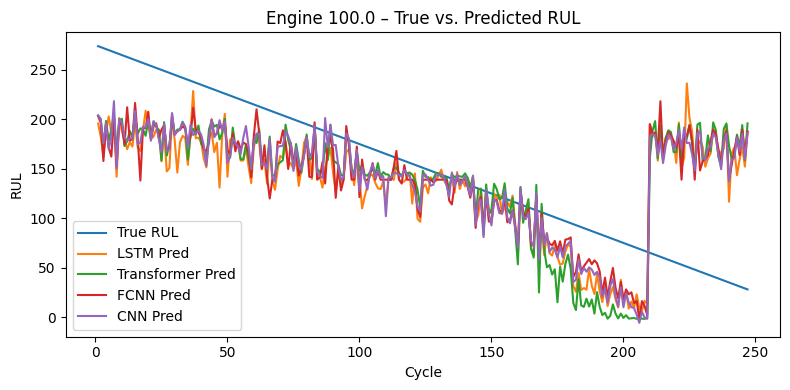

In [40]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]


true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.show()